# Accessing HTAN scRNA-seq with BQ and building Scanpy AnnData objects

```
Title:   Accessing HTAN scRNA-seq with BQ and building Scanpy AnnData objects.
Author:  David L Gibbs (david.gibbs@systemsbiology.org)
Created: 2022-3-29
Purpose: Building AnnData objects
URL:    NA 
Notes:  NA
```


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ncihtan/Community-Notebooks/blob/master/HTAN/Building_AnnData_with_Subset_of_Cells_from_BQ.ipynb#scrollTo=Zfbwi-8I8Ezd)

# 1. Introduction & Overview
[HTAN](https://humantumoratlas.org/) is a National Cancer Institute (NCI)-funded Cancer MoonshotSM initiative to construct 3-dimensional atlases of the dynamic cellular, morphological, and molecular features of human cancers as they evolve from precancerous lesions to advanced disease ( [Cell April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469) )

This notebook shows how cells of a particular type can be pulled from BigQuery tables and used to construct an [AnnData](https://anndata.readthedocs.io/en/latest/#:~:text=anndata%20is%20a%20Python%20package,operations%2C%20and%20a%20PyTorch%20interface.) object.

### 1.1 Notebook Goal

The goal of this notebook is to show users how public HTAN single cell data can be queried and assembled for further processing. The total time for executing this tutorial should be about **10 minutes**.

### 1.2 Inputs, Outputs, & Data

Input for this analysis is the HTAN single cell RNA sequencing data (Level 2, gene summarized). The data set is filtered according to a specific cell type and patient population. The data is pulled into this notebook a google cloud connection. More details are shown below.



# 2. Environment & Module Setup
The libraries used in this analysis fall into two categories: those needed for google cloud connection and those needed for the analysis itself.

In [ ]:
# GCP Libraries
from google.cloud import bigquery
from google.colab import auth

# Data Analytics
import numpy as np
from scipy import stats
from scipy import sparse
import scanpy as sc

The following snipet controls plotting parameters.

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

# 3. Google Authentication

Running the BigQuery cells in this notebook requires a Google Cloud Project, instructions for creating a project can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console). The instance needs to be authorized to bill the project for queries. For more information on getting started in the cloud see [Quick Start Guide to ISB-CGC](https://nbviewer.org/github/isb-cgc/Community-Notebooks/blob/master/Notebooks/Quick_Start_Guide_to_ISB_CGC.ipynb) and alternative authentication methods can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console).

In [ ]:
# if you're using Google Colab, authenticate to gcloud with the following
auth.authenticate_user()
# alternatively, use the gcloud SDK
#!gcloud auth application-default login

In [ ]:
## Setup ##

# set the google project that will be referenced for this notebook's computations
google_project = 'my-project'

# Create a client to access the data within BigQuery
client = bigquery.Client(google_project)

In the next sections, we select a subset of cells from BigQuery, 
and then construct an AnnData object, which lets us continue
working with the Scanpy library.

# 4. Building AnnDatas from BigQuery

If the data is transfered to big query in a way that preserves the AnnData structures, with X, obs, and var tables, then it should be easy to reconstruct the data structure and use Scanpy functions.

An AnnData requires three key parts, the gene counts X, the gene index var, and the cell barcodes obs. In the following snippet, we construct an SQL query to pull in the AnnData parts and transform them into a dataframe object. 

First we obtain the matrix of gene counts. These come from the CHOP scRNAseq table from HTAN in isb-cgc-bq. Specifically, this analysis will focus on mature, plasma-B-like, B cells in female individuals. 

In [ ]:
X = client.query("""

  SELECT
    iObs,
    iVar,
    X_value    
  FROM
    `isb-cgc-bq.HTAN.scRNAseq_CHOP_seurat_integrated_18MLLr_normal_final_rename_current`
  WHERE
    iObs in (
    SELECT 
      distinct(iObs) from 
      `isb-cgc-bq.HTAN.scRNAseq_CHOP_seurat_integrated_18MLLr_normal_final_rename_current`
      WHERE 
      Cell_Type = 'Mature_B' AND
      Projected_Cell_Type = 'Plasma-B-like' AND
      Gender = 'Female'
          )

    """).result().to_dataframe()

In [ ]:
X

Next, we will get the observations for each cell using the same method above in a new dataframe.

In [ ]:
obs = client.query("""

SELECT 
  iObs,
  Cell_Name,
  nCount_RNA,
  nFeature_RNA,
  Sample,
  Perc_mito,
  Seurat_Clusters,
  SpecimenType,
  Therapy,
  Cell_Type,
  Phase
FROM 
  `isb-cgc-bq.HTAN.scRNAseq_CHOP_seurat_integrated_18MLLr_normal_final_rename_current` 
WHERE
      Cell_Type = 'Mature_B' AND
      Projected_Cell_Type = 'Plasma-B-like' AND
      Gender = 'Female'
GROUP BY
  1,2,3,4,5,6,7,8,9,10,11

    """).result().to_dataframe()

In [ ]:
obs

Lastly, we'll get the gene index with the following snippet in the same manner.

In [ ]:
var = client.query("""

  SELECT
    iVar,
    Cell_Name,
    Gene_Name as GeneSymbol
  FROM
    `isb-cgc-bq.HTAN.scRNAseq_CHOP_seurat_integrated_18MLLr_normal_final_rename_current`
  WHERE
      Cell_Type = 'Mature_B' AND
      Projected_Cell_Type = 'Plasma-B-like' AND
      Gender = 'Female'
  GROUP BY 1,2,3
    """).result().to_dataframe()



In [ ]:
var

,iVar,Cell_Name,GeneSymbol
0,15948,MLLr870684_CCTCACATCCATCACC,SON
1,15163,MLLr870684_CCTCACATCCATCACC,FTL
2,14631,MLLr870684_CCTCACATCCATCACC,PKN1
3,958,MLLr870684_CCTCACATCCATCACC,ANP32E
4,5620,MLLr870684_CCTCACATCCATCACC,CCR6
...,...,...,...
28726,2594,MLLr879583_TCCAGAACAAATTAGG,SP110
28727,10459,MLLr879583_TCCAGAACAAATTAGG,HSPH1
28728,15961,MLLr879583_TCCAGAACAAATTAGG,CBR1
28729,12788,MLLr879583_TCCAGAACAAATTAGG,MPRIP


Before continuing, we need to do a little bit of table index shifting. This will shift the index of the tables we just made to 0.

In [ ]:
# shift the index to 0-index
var.index = var['GeneSymbol']
var.iVar = var.iVar-1
X.iVar = X.iVar-1

Then, the following lines will map the re-indexed X table we made to the obs table.

In [ ]:
# fix the obs index by reindexing
iObsDict = dict(zip(obs.iObs, obs.index))
X.iObs = [iObsDict[a] for a in X.iObs]

Next, we convert the pandas dataframe into a sparse matrix.

In [ ]:
sparseX2 = sparse.csr_matrix( (X.X_value, (X.iObs, X.iVar)), shape=(len(obs),len(var)))
sparseX2

<15x28731 sparse matrix of type '<class 'numpy.float64'>'
	with 28731 stored elements in Compressed Sparse Row format>

Finally, we use the sparse matrix, obs and var tables we have created in a AnnData object.

In [ ]:
# build the AnnData
adata = sc.AnnData(X=sparseX2, obs=obs, var=var)
adata.var_names_make_unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Next, in order to plot some results using the AnnData we created, we will select genes of interest from our data that exhibit high expression levels.

In [ ]:
geneCountsSum = (np.array(adata.X.sum(axis=0))[0,:])
highExprGenes = adata.var.iloc[ np.where(geneCountsSum > 60) ].index

Lastly, we can use scanpy plotting functions to visuialize the genes we identified above. Here, we plot their mean expression by cell phase and gene of interest. 

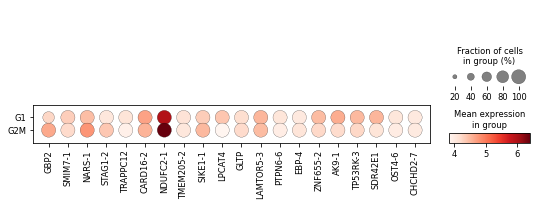

In [ ]:
# now we can use the plot functions of scanpy
sc.pl.dotplot(adata, highExprGenes, 'Phase', dendrogram=True)

We can also view the contents of the AnnData in a table format. The following table shows the counts of observations visualized above by group (cell phase).

In [ ]:
adata.obs.Phase.value_counts()

G1     13
G2M     2
Name: Phase, dtype: int64

Lastly, we can also plot the distribution of specific elements and group them accordingly. The following violin plot groups the FTL distribution by cell phase. 

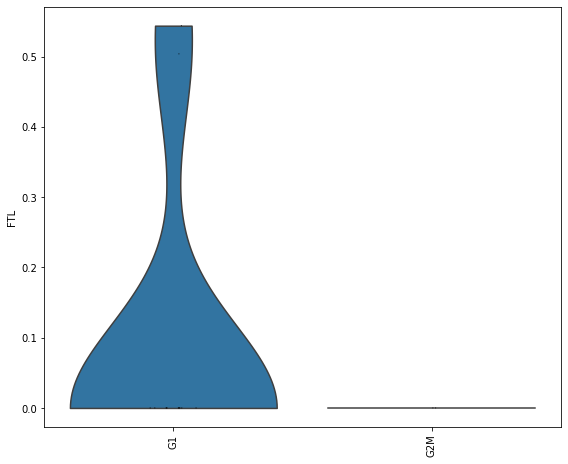

In [ ]:
sc.pl.violin(adata, 'FTL', groupby='Phase', rotation=90)

We have successfully pulled a subset of cells out of Google big query and constructed an AnnData object in Python. This notebook serves as a general guide, therefore it is best to recreate this analysis with your own questions and variables of interest.

If you have further questions, please reach out to the notebook authors or visit the links mentioned above and below.


# 5. Relevant Citations and Links


[HTAN Portal](https://humantumoratlas.org/)   


[Overview paper, Cell, April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469)

